In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os

def save_dataset(X_train, Y_train, X_test, Y_test, file_prefix="dataset"):
    np.savez(file_prefix, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

def load_dataset(file_prefix="dataset"):
    data = np.load(f"{file_prefix}.npz")
    return data["X_train"], data["Y_train"], data["X_test"], data["Y_test"]

# Calculate deviation from allowed angle ranges
def angle_deviation(angles):
    theta1, theta2, theta3 = angles
    deviation = 0
    if theta1 < -np.pi / 2 or theta1 > np.pi / 2:
        deviation += abs(theta1 - np.clip(theta1, -np.pi / 2, np.pi / 2))
    if theta2 < 0 or theta2 > np.pi / 2:
        deviation += abs(theta2 - np.clip(theta2, 0, np.pi / 2))
    if theta3 < -np.pi / 2 or theta3 > np.pi / 2:
        deviation += abs(theta3 - np.clip(theta3, -np.pi / 2, np.pi / 2))
    return deviation

In [6]:

# Link lengths (from table)
L1, L2, L3, L4, L5, L6, L7, L8, L9 = 0.055, 0.317, 0.045, 0.11, 0.005, 0.034, 0.015, 0.088, 0.204

# rotation matrix around the Z-axis
def RotZ(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0, 0],
                     [np.sin(theta),  np.cos(theta), 0, 0],
                     [0,              0,             1, 0],
                     [0,              0,             0, 1]])


def rotY(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta), 0],
                     [0, 1, 0, 0],
                     [-np.sin(theta), 0, np.cos(theta), 0],
                     [0, 0, 0, 1]])



def RotX(theta):
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(theta), -np.sin(theta), 0],
                     [0, np.sin(theta),  np.cos(theta), 0],
                     [0, 0, 0, 1]])

# translation matrix
def translation_matrix(tx, ty, tz):
    return np.array([[1, 0, 0, tx],
                     [0, 1, 0, ty],
                     [0, 0, 1, tz],
                     [0, 0, 0, 1]])





def forward_kinematics(theta1, theta2, theta3):
    theta1, theta2, theta3 =theta1, theta2, theta3
    # Base position
    x0, y0, z0 = 0, 0, 0 #L1
    base_position = np.array([x0, y0, z0, 1])

    # Transformation matrix from frame 0 to frame 1 (shoulder)
    T1_translation = translation_matrix(L6, -L4, (L2 + L3))

    T1 =  RotZ(theta1) @ T1_translation  @ RotX(np.pi / 2)  # Rotation around Z and X axes
    shoulder_position = T1 @ base_position

    # Transformation matrix from frame 1 to frame 2 (elbow)
    T2_translation = translation_matrix(L7, -L8, -L5)
    T2 = RotZ(theta2) @ T2_translation
    elbow_position = T1 @ T2 @ base_position

    # Transformation matrix from frame 2 to frame 3 (hand)
    T3_translation = translation_matrix(0, -L9, 0)
    T3 = RotZ(theta3) @ T3_translation
    wrist_position = T1 @ T2 @ T3 @ base_position

    # Extract joint positions (shoulder, elbow, wrist) for 3D plotting
    # Extract joint positions (shoulder, elbow, wrist) and adjust Z-coordinates by L1
    shoulder = shoulder_position[:3] + np.array([0, 0, L1])  # Correct Z-height
    elbow = elbow_position[:3] + np.array([0, 0, L1])        # Correct Z-height
    P_end_effector = wrist_position[:3] + np.array([0, 0, L1])        # Correct Z-height


    return P_end_effector


In [3]:
# Neural Network Architecture
class InverseKinematicsNN(nn.Module):
    def __init__(self):
        super(InverseKinematicsNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 3)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        return self.fc6(x)

# Custom loss function with penalty for exceeding limits
def custom_loss(output, target, criterion):
    mse_loss = criterion(output, target)
    
    # Add penalty for angles exceeding limits
    penalty = torch.sum(torch.relu(output[:, 0] - (np.pi / 2)) + torch.relu(-output[:, 0] - (np.pi / 2)))
    penalty += torch.sum(torch.relu(- output[:, 1]) + torch.relu(output[:, 1] - (np.pi / 2)))
    penalty += torch.sum(torch.relu(output[:, 2] - (np.pi / 2)) + torch.relu(-output[:, 2] - (np.pi / 2)))
    
    # Combine MSE loss with the penalty, weighted by 0.1
    return mse_loss + 0.1 * penalty



# Generate synthetic training data (example)
def generate_training_data(num_samples):
    X = []
    Y = []

  
    while len(X) < num_samples:
        # Random joint angles in radians
        theta_1 = np.random.uniform(-np.pi/2, np.pi/2)
        theta_2 = np.random.uniform(0, np.pi/2)
        theta_3 = np.random.uniform(-np.pi/2, np.pi/2)

        # Forward kinematics to get the end-effector position
        pos = forward_kinematics(theta_1, theta_2, theta_3)
       
        if 0.12 <= pos[2] <= 0.20:
            X.append(pos)
            Y.append([theta_1, theta_2, theta_3])

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

In [4]:

def train_and_evaluate_model(optimizer_fn, lr, X_train, Y_train, X_test, Y_test, num_epochs=50000):

    model = InverseKinematicsNN()
    optimizer = optimizer_fn(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    loss_data = []
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

    best_loss = float('inf')
    best_model = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = custom_loss(outputs, Y_train, criterion)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        loss_data.append(loss.item())
        
        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

       
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()  


    model.load_state_dict(best_model)  
    model.eval()
    total_error, total_deviation = 0, 0
    with torch.no_grad():
        for i in range(len(X_test)):
            test_position = X_test[i]
            true_angles = Y_test[i]
            predicted_angles = model(test_position).detach().numpy()
            P_predicted = forward_kinematics(predicted_angles[0], predicted_angles[1], predicted_angles[2])
            P_target = test_position.detach().numpy()
            error = np.linalg.norm(P_target - P_predicted)
            total_error += error
            
            deviation = angle_deviation(predicted_angles)
            total_deviation += deviation

    average_error = total_error / len(X_test)
    average_deviation = total_deviation / len(X_test)
    
   
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    torch.save(best_model, f"{exp_name}/best_model.pth")
    torch.save(model.state_dict(), f"{exp_name}/latest_model.pth")

    return model, loss_data, average_error, average_deviation


def save_experiment_results(exp_name, loss_data, average_error, average_deviation):
    os.makedirs(exp_name, exist_ok=True)
    np.save(f"{exp_name}/loss_data.npy", loss_data)
    with open(f"{exp_name}/metrics.txt", "w") as f:
        f.write(f"Average Error: {average_error}\n")
        f.write(f"Average Angle Deviation: {average_deviation}\n")

def plot_loss_curve(loss_data, exp_name):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_data, label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error Loss + penalty')
    plt.title(f'Loss Plot for {exp_name}')
    plt.grid(True)
    plt.savefig(f"{exp_name}/loss_plot.png")
    plt.close()


In [5]:
# Comment out for training
"""if __name__ == "__main__":
    #Generate or load consistent training and testing datasets
    X_train, Y_train = generate_training_data(20000)
    X_test, Y_test = generate_training_data(10000)
    save_dataset(X_train, Y_train, X_test, Y_test)
    
    X_train, Y_train, X_test, Y_test = load_dataset()

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train)
    Y_train = torch.tensor(Y_train)
    X_test = torch.tensor(X_test)
    Y_test = torch.tensor(Y_test)
    
   
    # Experiment 1: SGD optimizer with different learning rate
    exp_name = "experiment_sgd_lr0.1"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.SGD, lr=0.1, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)
    
    # Experiment 2: Adam optimizer with different learning rate
    exp_name = "experiment_adam_lr0.0002"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.Adam, lr=0.0002, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)

    # Experiment 3: RMSprop optimizer with learning rate 0.001
    exp_name = "experiment_rmsprop_lr0.001"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.RMSprop, lr=0.001, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)

    # Experiment 4: Adam optimizer with higher learning rate 0.01
    exp_name = "experiment_adam_lr0.01"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.Adam, lr=0.01, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)

    # Experiment 5: SGD optimizer with lower learning rate 0.01
    exp_name = "experiment_sgd_lr0.01"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.SGD, lr=0.01, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)
    
    # Experiment 6: Adam optimizer with learning rate 0.001
    exp_name = "experiment_adam_lr0.001"
    model, loss_data, avg_error, avg_dev = train_and_evaluate_model(optim.Adam, lr=0.001, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)
    save_experiment_results(exp_name, loss_data, avg_error, avg_dev)
    plot_loss_curve(loss_data, exp_name)


Epoch [500/50000], Loss: 0.2313
Epoch [1000/50000], Loss: 0.1884
Epoch [1500/50000], Loss: 0.1747
Epoch [2000/50000], Loss: 0.1393
Epoch [2500/50000], Loss: 0.1077
Epoch [3000/50000], Loss: 0.1075
Epoch [3500/50000], Loss: 0.0981
Epoch [4000/50000], Loss: 0.0911
Epoch [4500/50000], Loss: 0.0833
Epoch [5000/50000], Loss: 0.0810
Epoch [5500/50000], Loss: 0.0661
Epoch [6000/50000], Loss: 0.0677
Epoch [6500/50000], Loss: 0.0617
Epoch [7000/50000], Loss: 0.0590
Epoch [7500/50000], Loss: 0.0545
Epoch [8000/50000], Loss: 0.0524
Epoch [8500/50000], Loss: 0.0502
Epoch [9000/50000], Loss: 0.0502
Epoch [9500/50000], Loss: 0.0485
Epoch [10000/50000], Loss: 0.0445
Epoch [10500/50000], Loss: 0.0459
Epoch [11000/50000], Loss: 0.0452
Epoch [11500/50000], Loss: 0.0436
Epoch [12000/50000], Loss: 0.0424
Epoch [12500/50000], Loss: 0.0429
Epoch [13000/50000], Loss: 0.0416
Epoch [13500/50000], Loss: 0.0414
Epoch [14000/50000], Loss: 0.0412
Epoch [14500/50000], Loss: 0.0411
Epoch [15000/50000], Loss: 0.0409


In [20]:

experiments = {
    "experiment_sgd_lr0.1": np.load("experiment_sgd_lr0.1/loss_data.npy"),
    "experiment_adam_lr0.0002": np.load("experiment_adam_lr0.0002/loss_data.npy"),
    "experiment_rmsprop_lr0.001": np.load("experiment_rmsprop_lr0.001/loss_data.npy"),
    "experiment_adam_lr0.01": np.load("experiment_adam_lr0.01/loss_data.npy"),
    "experiment_sgd_lr0.01": np.load("experiment_sgd_lr0.01/loss_data.npy"),
    "experiment_adam_lr0.001": np.load("experiment_adam_lr0.001/loss_data.npy"),
}


X_train, Y_train = np.load("dataset.npz")['X_train'], np.load("dataset.npz")['Y_train']
X_test, Y_test = np.load("dataset.npz")['X_test'], np.load("dataset.npz")['Y_test']
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)


class InverseKinematicsNN(nn.Module):
    def __init__(self):
        super(InverseKinematicsNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 3)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        return self.fc6(x)



def angle_deviation(angles):
    theta1, theta2, theta3 = angles
    deviation_theta1 = abs(theta1 - np.clip(theta1, -np.pi / 2, np.pi / 2))
    deviation_theta2 = abs(theta2 - np.clip(theta2, 0, np.pi / 2))
    deviation_theta3 = abs(theta3 - np.clip(theta3, -np.pi / 2, np.pi / 2))
    return deviation_theta1, deviation_theta2, deviation_theta3

errors_dict = {}
deviations_dict = {"theta1": {}, "theta2": {}, "theta3": {}}

for exp_name in experiments.keys():
    model = InverseKinematicsNN()
    model.load_state_dict(torch.load(f"{exp_name}/best_model.pth"))
    model.eval()
    errors = []
    deviations_theta1 = []
    deviations_theta2 = []
    deviations_theta3 = []
    
    with torch.no_grad():
        for i in range(len(X_test)):
            test_position = X_test[i]  
            true_angles = Y_test[i] 

            
            predicted_angles = model(test_position.unsqueeze(0))
            predicted_angles = predicted_angles.squeeze().detach().numpy()

            
            P_predicted = forward_kinematics(predicted_angles[0], predicted_angles[1], predicted_angles[2])
            P_target = test_position.detach().numpy()  

           
            error = np.linalg.norm(P_target - P_predicted)
            errors.append(error)

           
            deviation_theta1, deviation_theta2, deviation_theta3 = angle_deviation(predicted_angles)
            deviations_theta1.append(deviation_theta1)
            deviations_theta2.append(deviation_theta2)
            deviations_theta3.append(deviation_theta3)
    
    errors_dict[exp_name] = np.array(errors)
    deviations_dict["theta1"][exp_name] = np.array(deviations_theta1)
    deviations_dict["theta2"][exp_name] = np.array(deviations_theta2)
    deviations_dict["theta3"][exp_name] = np.array(deviations_theta3)
    
   
    np.save(f"{exp_name}/errors.npy", errors_dict[exp_name])
    np.save(f"{exp_name}/deviations_theta1.npy", deviations_dict["theta1"][exp_name])
    np.save(f"{exp_name}/deviations_theta2.npy", deviations_dict["theta2"][exp_name])
    np.save(f"{exp_name}/deviations_theta3.npy", deviations_dict["theta3"][exp_name])



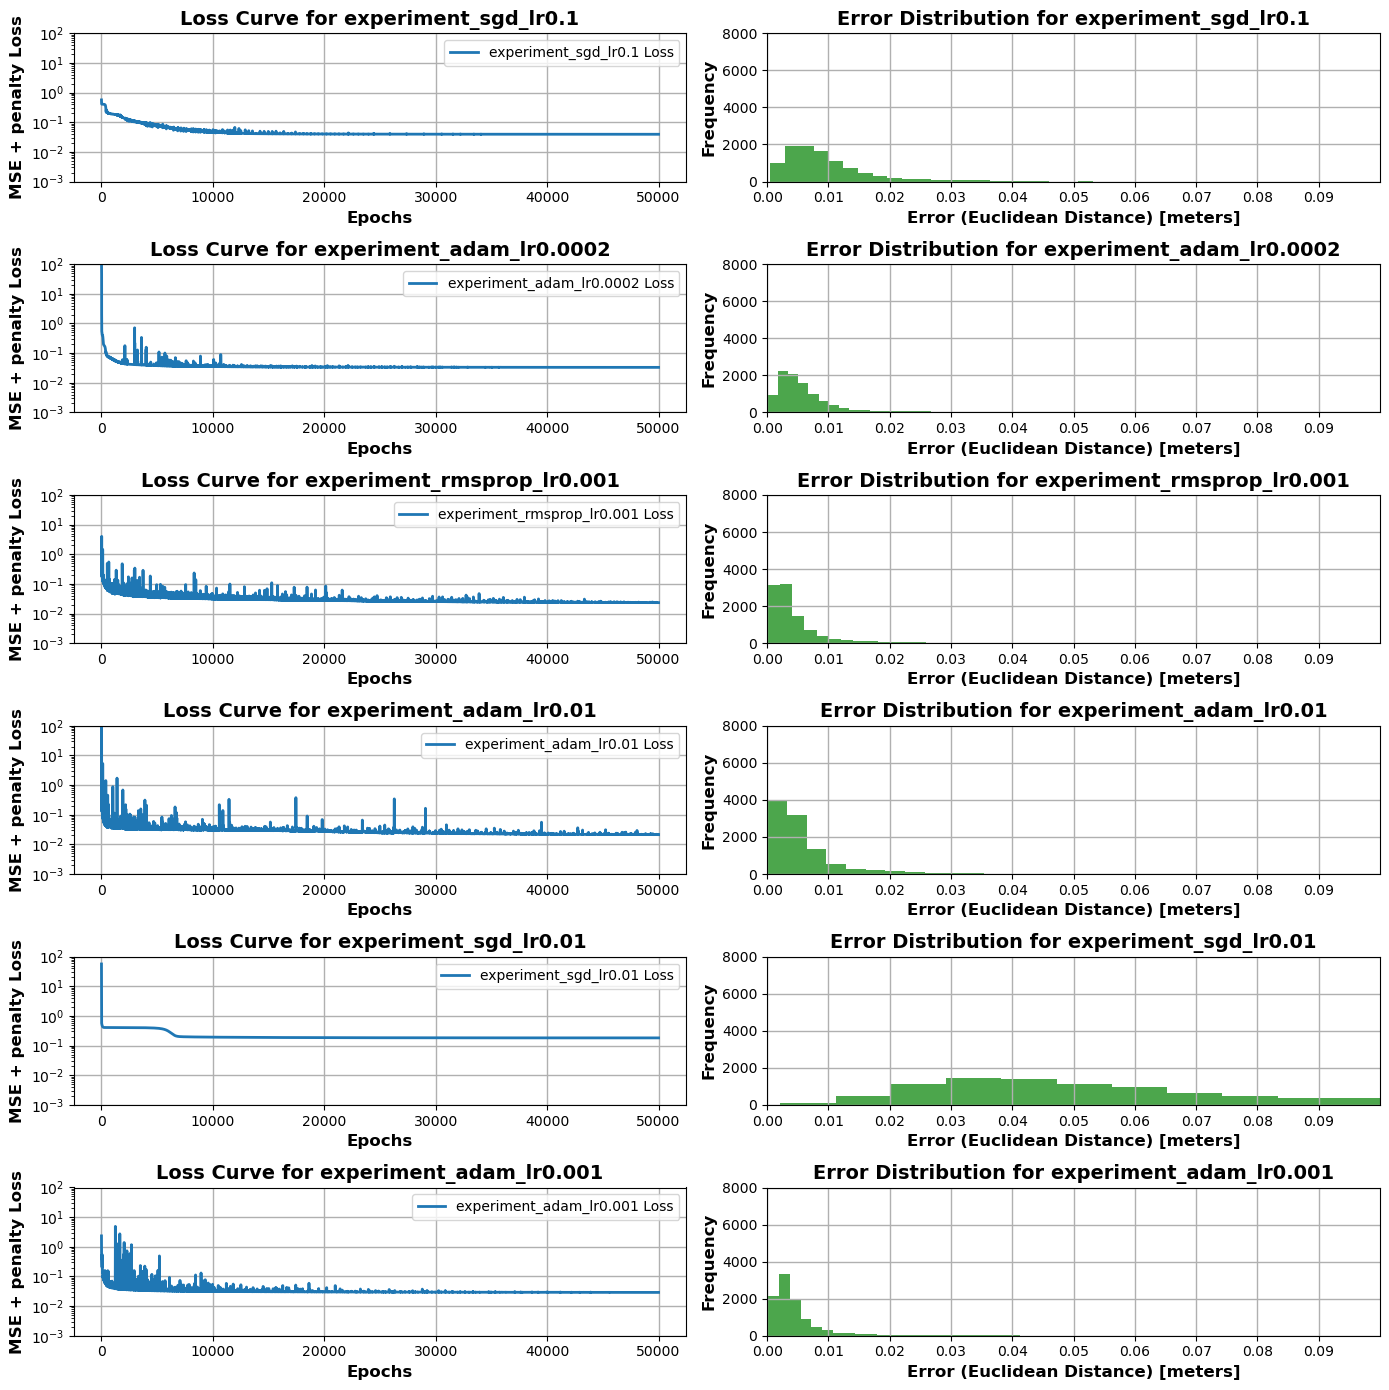

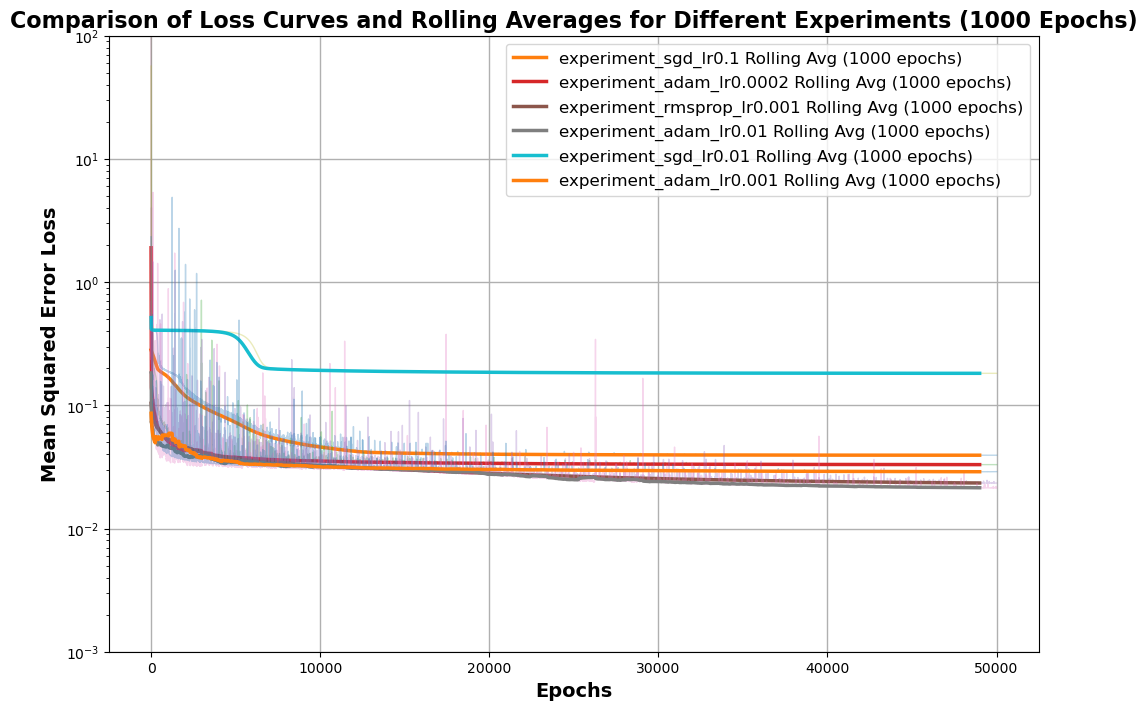

In [22]:

fig, axes = plt.subplots(6, 2, figsize=(14, 14))
y_limits = (1e-3, 1e2)  
axes = axes.ravel()

for idx, (exp_name, loss_data) in enumerate(experiments.items()):
    axes[idx * 2].plot(loss_data, label=f'{exp_name} Loss', linewidth=2)
    axes[idx * 2].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    axes[idx * 2].set_ylabel('MSE + penalty Loss', fontsize=12, fontweight='bold')
    axes[idx * 2].set_yscale('log')
    axes[idx * 2].set_ylim(y_limits)
    axes[idx * 2].set_title(f'Loss Curve for {exp_name}', fontsize=14, fontweight='bold')
    axes[idx * 2].legend(fontsize=10)
    axes[idx * 2].grid(True, linewidth=1)

    errors = errors_dict[exp_name]
    axes[idx * 2 + 1].hist(errors, bins=30, color='green', alpha=0.7)
    axes[idx * 2 + 1].set_title(f'Error Distribution for {exp_name}', fontsize=14, fontweight='bold')
    axes[idx * 2 + 1].set_xlabel('Error (Euclidean Distance) [meters]', fontsize=12, fontweight='bold')
    axes[idx * 2 + 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[idx * 2 + 1].set_ylim(0, 8000)
    axes[idx * 2 + 1].set_xlim(0, 0.1)
    axes[idx * 2 + 1].set_xticks(np.arange(0, 0.1, 0.01))
    axes[idx * 2 + 1].grid(True, linewidth=1)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for exp_name, loss_data in experiments.items():
    
    plt.plot(loss_data, alpha=0.3, linewidth=1) 
   
    rolling_average = np.convolve(loss_data, np.ones(1000) / 1000, mode='valid')
    plt.plot(rolling_average, label=f'{exp_name} Rolling Avg (1000 epochs)', linewidth=2.5)

plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Mean Squared Error Loss', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.ylim(y_limits)
plt.title('Comparison of Loss Curves and Rolling Averages for Different Experiments (1000 Epochs)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linewidth=1)
plt.show()


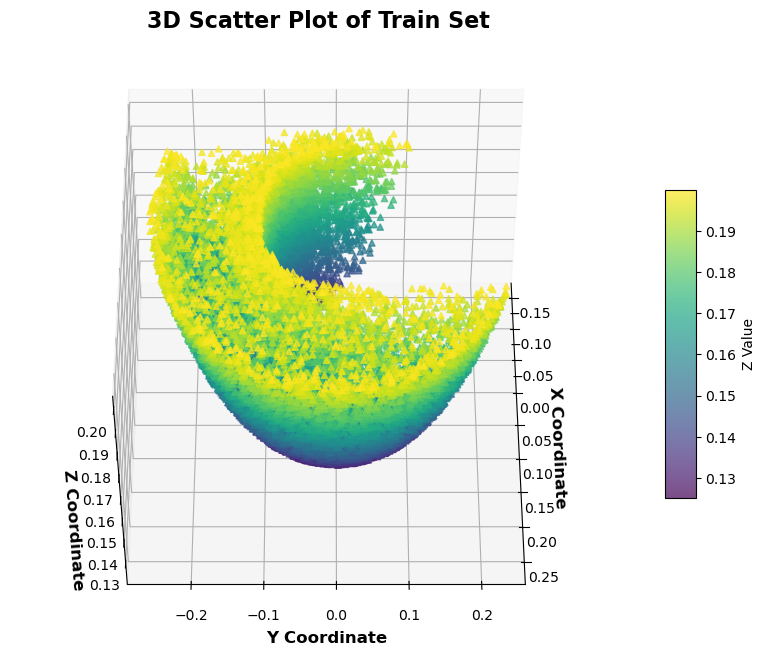

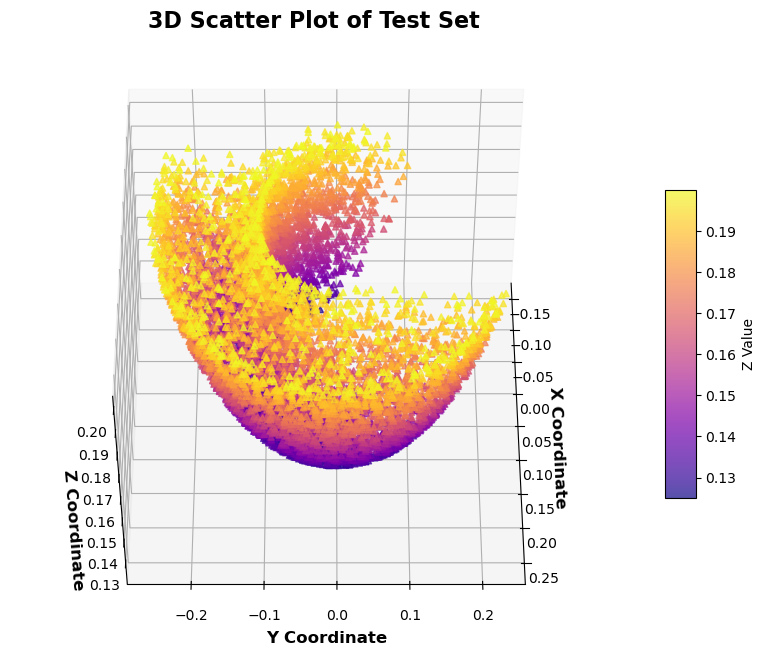

In [12]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], 
                     c=X_train[:, 2], cmap='viridis', marker='^', alpha=0.7)


cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Z Value')


ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax.set_zlabel('Z Coordinate', fontsize=12, fontweight='bold')
ax.set_title('3D Scatter Plot of Train Set', fontsize=16, fontweight='bold')


ax.grid(True, linestyle='--', alpha=0.6)
ax.view_init(elev=50, azim=0)
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                     c=X_test[:, 2], cmap='plasma', marker='^', alpha=0.7)
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Z Value')

ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax.set_zlabel('Z Coordinate', fontsize=12, fontweight='bold')
ax.set_title('3D Scatter Plot of Test Set ', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)
ax.view_init(elev=50, azim=0)


plt.show()



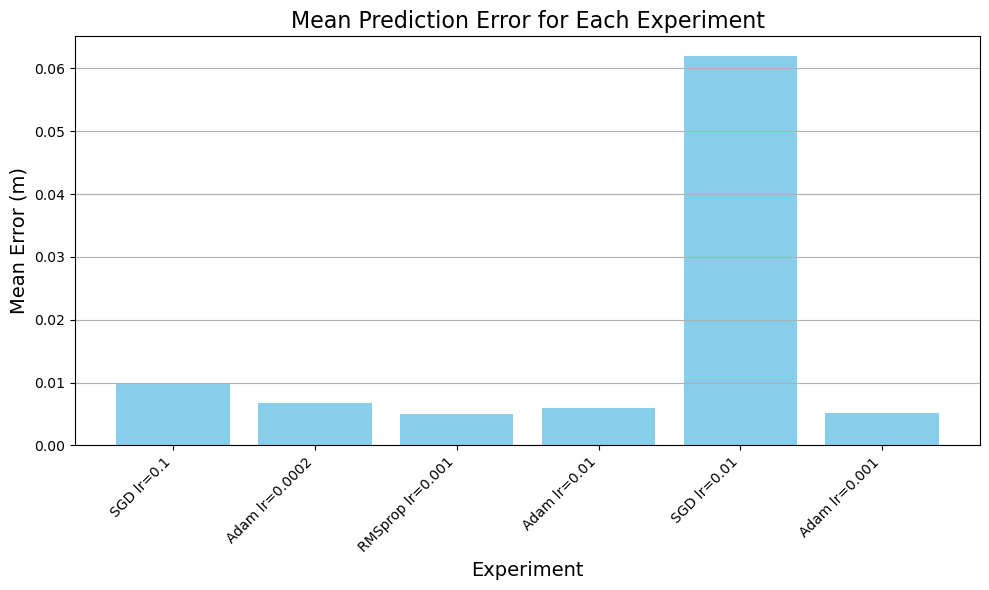

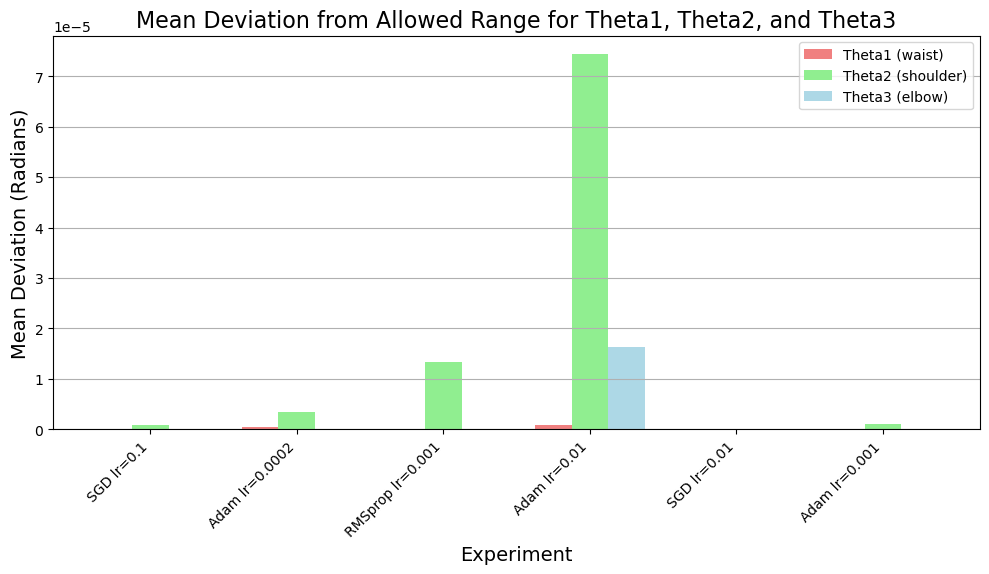

In [18]:
# Load loss data for each experiment
experiments = {
    "SGD lr=0.1": np.load("experiment_sgd_lr0.1/loss_data.npy"),
    "Adam lr=0.0002": np.load("experiment_adam_lr0.0002/loss_data.npy"),
    "RMSprop lr=0.001": np.load("experiment_rmsprop_lr0.001/loss_data.npy"),
    "Adam lr=0.01": np.load("experiment_adam_lr0.01/loss_data.npy"),
    "SGD lr=0.01": np.load("experiment_sgd_lr0.01/loss_data.npy"),
    "Adam lr=0.001": np.load("experiment_adam_lr0.001/loss_data.npy"),
}


# Load error data for each experiment
errors_dict = {
    "SGD lr=0.1": np.load("experiment_sgd_lr0.1/errors.npy"),
    "Adam lr=0.0002": np.load("experiment_adam_lr0.0002/errors.npy"),
    "RMSprop lr=0.001": np.load("experiment_rmsprop_lr0.001/errors.npy"),
    "Adam lr=0.01": np.load("experiment_adam_lr0.01/errors.npy"),
    "SGD lr=0.01": np.load("experiment_sgd_lr0.01/errors.npy"),
    "Adam lr=0.001": np.load("experiment_adam_lr0.001/errors.npy"),
}


plt.figure(figsize=(10, 6))
mean_errors = {label: np.mean(errors) for label, errors in errors_dict.items()}
plt.bar(mean_errors.keys(), mean_errors.values(), color='skyblue')

plt.title("Mean Prediction Error for Each Experiment", fontsize=16)
plt.xlabel("Experiment", fontsize=14)
plt.ylabel("Mean Error (m)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


deviations_theta1 = {
    "SGD lr=0.1": np.load("experiment_sgd_lr0.1/deviations_theta1.npy"),
    "Adam lr=0.0002": np.load("experiment_adam_lr0.0002/deviations_theta1.npy"),
    "RMSprop lr=0.001": np.load("experiment_rmsprop_lr0.001/deviations_theta1.npy"),
    "Adam lr=0.01": np.load("experiment_adam_lr0.01/deviations_theta1.npy"),
    "SGD lr=0.01": np.load("experiment_sgd_lr0.01/deviations_theta1.npy"),
    "Adam lr=0.001": np.load("experiment_adam_lr0.001/deviations_theta1.npy"),
}

deviations_theta2 = {
    "SGD lr=0.1": np.load("experiment_sgd_lr0.1/deviations_theta2.npy"),
    "Adam lr=0.0002": np.load("experiment_adam_lr0.0002/deviations_theta2.npy"),
    "RMSprop lr=0.001": np.load("experiment_rmsprop_lr0.001/deviations_theta2.npy"),
    "Adam lr=0.01": np.load("experiment_adam_lr0.01/deviations_theta2.npy"),
    "SGD lr=0.01": np.load("experiment_sgd_lr0.01/deviations_theta2.npy"),
    "Adam lr=0.001": np.load("experiment_adam_lr0.001/deviations_theta2.npy"),
}

deviations_theta3 = {
    "SGD lr=0.1": np.load("experiment_sgd_lr0.1/deviations_theta3.npy"),
    "Adam lr=0.0002": np.load("experiment_adam_lr0.0002/deviations_theta3.npy"),
    "RMSprop lr=0.001": np.load("experiment_rmsprop_lr0.001/deviations_theta3.npy"),
    "Adam lr=0.01": np.load("experiment_adam_lr0.01/deviations_theta3.npy"),
    "SGD lr=0.01": np.load("experiment_sgd_lr0.01/deviations_theta3.npy"),
    "Adam lr=0.001": np.load("experiment_adam_lr0.001/deviations_theta3.npy"),
}


mean_deviations_theta1 = {label: np.mean(deviations) for label, deviations in deviations_theta1.items()}
mean_deviations_theta2 = {label: np.mean(deviations) for label, deviations in deviations_theta2.items()}
mean_deviations_theta3 = {label: np.mean(deviations) for label, deviations in deviations_theta3.items()}


labels = list(mean_deviations_theta1.keys())  
theta1_means = list(mean_deviations_theta1.values())
theta2_means = list(mean_deviations_theta2.values())
theta3_means = list(mean_deviations_theta3.values())

x = np.arange(len(labels))  
width = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))


rects1 = ax.bar(x - width, theta1_means, width, label='Theta1 (waist)', color='lightcoral')
rects2 = ax.bar(x, theta2_means, width, label='Theta2 (shoulder)', color='lightgreen')
rects3 = ax.bar(x + width, theta3_means, width, label='Theta3 (elbow)', color='lightblue')


ax.set_xlabel('Experiment', fontsize=14)
ax.set_ylabel('Mean Deviation (Radians)', fontsize=14)
ax.set_title('Mean Deviation from Allowed Range for Theta1, Theta2, and Theta3', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()


ax.grid(True, axis='y')
fig.tight_layout()

plt.show()